In [1]:
import os
import flopy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model_ws = 'Results'
modelname = 'Ex05'
exe_name = '/home/harsh/Desktop/modflow_flopy/flopyCourse/mf6'
sim = flopy.mf6.MFSimulation(sim_name=modelname, exe_name=exe_name, sim_ws=model_ws)

In [3]:
perioddata = [(1,1,1)]
nper = len(perioddata)
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=perioddata, time_units='days')

In [4]:
ims = flopy.mf6.ModflowIms(sim)

In [5]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=modelname, save_flows=True)

In [6]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500
top = np.ones((nrow, ncol), dtype=np.int32)
for i in range(ncol):
    top[:,i] = 396 - i*4
botm = [220, 200, 0]
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top, botm=botm)

In [8]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=320)

In [9]:
kh = [50, 0.01, 200]
kv = [10, 0.01, 20]
icelltype=[1,0,0]
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                             icelltype=icelltype, k=kh, k33=kv)

In [10]:
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.01)#rcha is recharge for all cells

In [11]:
wel_spd = {0:[[(2,10,9), -150000]]}
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd)

In [12]:
riv_spd = {0:[[(0,i,19), 320, 1e5, 318] for i in range(nrow)]}
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

In [13]:
hname = '{}.hds'.format(modelname)
cname = '{}.cbc'.format(modelname)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
                           head_filerecord=hname,
                           saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [14]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model Ex05...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /home/harsh/Desktop/modflow_flopy/flopyCourse/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

  MODFLOW 6 compiled May  4 2021 17:51:29 with GFORTRAN compiler (ver. 9.3.0)

This software has been approved for release by the U.S. Geological 


(True, [])

In [19]:
from ipywidgets import interact

fpth = os.path.join(model_ws, modelname+'.hds')
hobj = flopy.utils.HeadFile(fpth)
hds = hobj.get_data()

fpth = os.path.join(model_ws, cname)
cobj = flopy.utils.CellBudgetFile(fpth, precision=hobj.precision)

spd = cobj.get_data(text='DATA-SPDIS')

@interact(x=(0,2,1))
def f(x):
    fig, ax = plt.subplots(figsize=(15, 20))
    mapview = flopy.plot.PlotMapView(model=gwf, layer=x)
    hplot = mapview.plot_array(hds)
    mapview.plot_specific_discharge(spd) #quiver or velocity vector
    linecollection = mapview.plot_grid()
    plt.colorbar(hplot, shrink=0.75)

interactive(children=(IntSlider(value=1, description='x', max=2), Output()), _dom_classes=('widget-interact',)…

In [21]:
#Downloaded modpath executable from MODFLOW Github
mpexe = '/home/harsh/Desktop/modflow_flopy/flopyCourse/mp7'

partlocs = [(0, i, 0) for i in range(nrow)]
particledata = flopy.modpath.ParticleData(partlocs, structured=True)
pg = flopy.modpath.ParticleGroup(particledata=particledata)

In [22]:
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp',
                           model_ws = model_ws,
                           flowmodel=gwf,
                           exe_name=mpexe,
                           headfilename=hname,
                           budgetfilename=cname)
mpbas = flopy.modpath.Modpath7Bas(mp)
mpsim = flopy.modpath.Modpath7Sim(mp, trackingdirection='forward',
                                 weaksinkoption='pass_through',
                                 weaksourceoption='pass_through',
                                 stoptimeoption='extend',
                                 particlegroups=pg)
mp.write_input()
mp.run_model()

FloPy is using the following  executable to run the model: /home/harsh/Desktop/modflow_flopy/flopyCourse/mp7

MODPATH Version 7.2.001   
Program compiled Feb 18 2021 20:25:19 with IFORT compiler (ver. 19.10.3)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        21 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

In [23]:
fname = os.path.join(model_ws, modelname+'_mp.mppth')
p = flopy.utils.PathlineFile(fname).get_alldata()

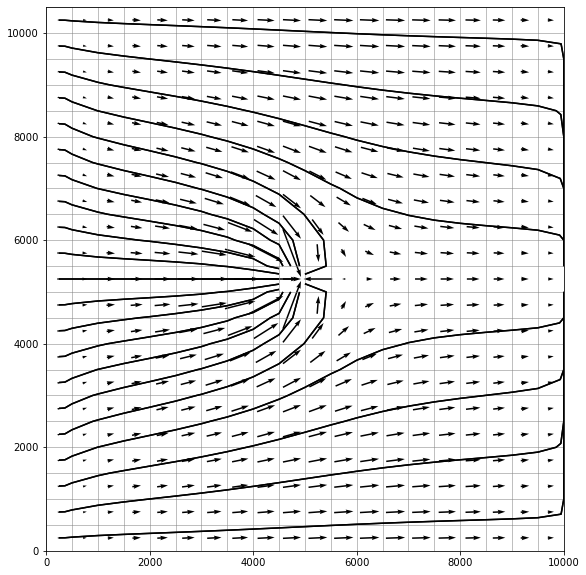

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
mapview = flopy.plot.PlotMapView(model=gwf, layer=2)
mapview.plot_grid(lw=0.5)
mapview.plot_pathline(p, layer='all', color='k')
mapview.plot_specific_discharge(spd)